![Hothead](./hotheadlogo.jpg)
<!-- Logo does not display on GitLab -->

In [1]:
import tweepy           # CONSUMES TWITTER API
import pandas as pd     # DATA STRUCTURE AND ANALYSIS TOOL
import numpy as np      # NUMBER COMPUTING

from textblob import TextBlob    # NATURAL LANGUAGE PROCESSING
import re                        # REGULAR EXPRESSIONS
import requests                  # REQUESTS FROM ONLINE
from graphviz import Digraph     # FOR DISPLAYING OUR GRAPH

# PLOTTING IMPORTS
from IPython.display import display
import matplotlib.pyplot as plt1
import seaborn as sns
%matplotlib inline

# TWITTER API ACCESS KEYS
from credentials import *

# API's setup:
def twitter_setup():

    # AUTHENTICATION
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # RETURN API OBJECT
    api = tweepy.API(auth)
    return api

def clean_tweet(tweet):
    
    # REMOVE LINKS AND SPECIAL CHARACTERS
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analyze_sentiment(tweet):

    # ANALYZE POLARITY
    analysis = TextBlob(clean_tweet(tweet))
    
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
    
# API OBJECT
extractor = twitter_setup()

In [5]:
def analyze(widths, user, dot, location="none"):
    
    if (location == "none"):
        
        # EXTRACT THE USER'S RECENT TWEETS
        tweets = extractor.user_timeline(screen_name=user, count=200)
        
    else:
        
        # PERFORM THE GEO SEARCH
        places = extractor.geo_search(query=user, granularity="city")
        place_id = places[0].id

        # EXTRACT 200 MOST RECENT TWEETS
        tweets = extractor.search(q="place:%s" % place_id, count=200)

    print("Number of tweets extracted from {}: {}.\n\n".format(user, len(tweets)))

    # PANDAS DATAFRAME
    data = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])

    # DISPLAY SETTING
    pd.set_option('display.max_colwidth', -1)


    # ADD THE RELEVANT DATA TO THE DATAFRAME
    data['Length']  = np.array([len(tweet.text) for tweet in tweets])
    if (location != "none"):
        data['Location'] = np.array([tweet.place.full_name for tweet in tweets])
    data['ID']   = np.array([tweet.id for tweet in tweets])
    data['Date'] = np.array([tweet.created_at for tweet in tweets])
    data['Source'] = np.array([tweet.source for tweet in tweets])
    data['Likes']  = np.array([tweet.favorite_count for tweet in tweets])
    data['RTs']    = np.array([tweet.retweet_count for tweet in tweets])

    # DISPLAY FIRST 10 TWEETS
    display(data.head(10))

    # MEAN LENGTH
    meanLength = np.mean(data['Length'])
    
    # MEAN LIKES
    meanLikes = np.mean(data['Likes'])

    data['SA'] = np.array([ analyze_sentiment(tweet) for tweet in data['Tweets'] ])

    # GET THE PERCENTAGES
    pos_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] > 0]
    neg_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] < 0]
    moreLike_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['Likes'][index] >= meanLikes]
    fewerLike_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['Likes'][index] < meanLikes]
    longer_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['Length'][index] >= meanLength]
    shorter_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['Length'][index] < meanLength]
    
    posAndNegTweets = len(pos_tweets) + len(neg_tweets)
    likeTweets = len(moreLike_tweets) + len(fewerLike_tweets)
    lengthTweets = len(longer_tweets) + len(shorter_tweets)

    # PERCENTAGE STUFF
    percentPos = format(len(pos_tweets)*100/posAndNegTweets, '.2f');
    percentNeg = format(len(neg_tweets)*100/posAndNegTweets, '.2f');
    
    percentMoreLike = format(len(moreLike_tweets)*100/likeTweets, '.2f');
    percentFewerLike = format(len(fewerLike_tweets)*100/likeTweets, '.2f');
    
    percentLong = format(len(longer_tweets)*100/lengthTweets, '.2f');
    percentShort = format(len(shorter_tweets)*100/lengthTweets, '.2f');
    
    widths['pos'] = str(float(percentPos)/100 + 1)
    widths['neg'] = str(float(percentNeg)/100 + 1)
    widths['pop'] = str(float(percentMoreLike)/100 + 1)
    widths['unpop'] = str(float(percentFewerLike)/100 + 1)
    widths['long'] = str(float(percentLong)/100 + 1)
    widths['short'] = str(float(percentShort)/100 + 1)
    
    # BUILD THE TREE
    for index, tweet in enumerate(data['Tweets']):

        if data['SA'][index] > 0:
            dot.node(str(data['ID'][index]) + "1", "", style='invis', width='.01', nodesep='0.02')
            dot.edge('POSITIVE', str(data['ID'][index]) + "1", style='invis', weight='2')
        elif data['SA'][index] < 0:
            dot.node(str(data['ID'][index]) + "1", "", style='invis', width='.01', nodesep='0.02')
            dot.edge('NEGATIVE', str(data['ID'][index]) + "1", style='invis', weight='2')

        if data['Likes'][index] >= meanLikes:
            dot.node(str(data['ID'][index]) + "2", "", style='invis', width='.01', nodesep='0.02')
            dot.edge('POPULAR', str(data['ID'][index]) + "2", style='invis', weight='2')
        else:
            dot.node(str(data['ID'][index]) + "2", "", style='invis', width='.01', nodesep='0.02')
            dot.edge('UNPOPULAR', str(data['ID'][index]) + "2", style='invis', weight='3')

        if data['Length'][index] >= meanLength:
            dot.node(str(data['ID'][index]) + "3", "", style='invis', width='.01', nodesep='0.02')
            dot.edge('LONG', str(data['ID'][index]) + "3", style='invis', weight='2')
        else:
            dot.node(str(data['ID'][index]) + "3", "", style='invis', width='.01', nodesep='0.02')
            dot.edge('SHORT', str(data['ID'][index]) + "3", style='invis', weight='3')    

Would you like to search by username (u), or location (l)? u

Please enter a username: @ ralph
Number of tweets extracted from ralph: 200.




Tweets  \
0  RT @uygar_soenmez: Wisdom in the @XING_de and remote offices. @tenderlove honored, thankful and excited to have you here https://t.co/YSx12…    
1  @domanske Ja, vielleicht 🤔                                                                                                                      
2  @domanske Job in Lüneburg wäre mal was... ¯\_(ツ)_/¯ #neid                                                                                       
3  @Waldkreis @ADFC_Berlin @BurkhardStork @martinhikel WTFWTFWTFWTFWTFWTF ¯\_(ツ)_/¯\nAllen das Spielzeu... äh Auto wegn… https://t.co/uIHRUr4aHI   
4  I like this idea. Takes the pressure off the speaker. https://t.co/xJ7QDP3tP2                                                                   
5  RT @roccoblues: Do you need an experienced Backend Developer? I'm available again for freelance work starting in July. #golang #ruby #hambu…    
6  @sn0wgirl @HerrBertling Never, wenn Götze schon wackelt 😂                                                                                       
7  @HerrBertling @sn0wgirl "André, ich habe heute leider kein Panini-Bild für dich!"                                                               
8  @sn0wgirl Götze ist auf den Stickern? Mutig... 😜                                                                                                
9  Bahnisch: "Sie Hanschluss"\nDeutsch: "Sie haben Anschluss"\n#servicetweet                                                                       

   Length                  ID                Date              Source  Likes  \
0  140     992499618176012290 2018-05-04 20:22:03  Twitter Lite        0       
1  26      992053806509842433 2018-05-03 14:50:33  Twitter Lite        0       
2  57      992052727810322433 2018-05-03 14:46:16  Twitter Lite        0       
3  140     991979398885707776 2018-05-03 09:54:53  Twitter Lite        5       
4  77      991978266427785216 2018-05-03 09:50:23  Twitter Lite        1       
5  140     989209739367211008 2018-04-25 18:29:15  Twitter Lite        0       
6  57      989032653612601345 2018-04-25 06:45:34  Twitter Lite        1       
7  81      988843722614992896 2018-04-24 18:14:49  Twitter Lite        1       
8  48      988842587296616448 2018-04-24 18:10:19  Twitter Lite        0       
9  71      986506208659066880 2018-04-18 07:26:23  Twitter Web Client  1       

   RTs  
0  8    
1  0    
2  0    
3  0    
4  0    
5  15   
6  0    
7  0    
8  0    
9  0

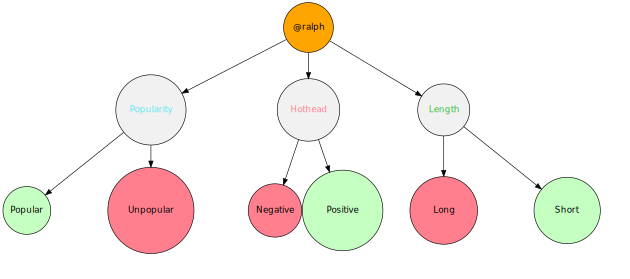

In [6]:
# DICT FOR RADII OF NODES
widths = {}

# COLOR DEFINITIONS
red = "#ff7f8e"
green = "#c5ffc1"
grey = "#f1f1f1"
blue = "#60e3f7"
darkgreen = "#34bc3b"

# INITIALIZING GRAPH
dot = Digraph(comment='Testing', node_attr={

 'shape': 'circle', 
 'style': 'filled', 
 'width': '0.4', 
 'color': 'black', 
 'fontsize': '14',
 'ordering': 'out',
 'fontname': 'berlin sans fb'

}, graph_attr={

 'nodesep': '0.02',
 'size': '8.75'

})

option = input("Would you like to search by username (u), or location (l)? ")

print()

# SEARCH BY LOCATION OR HANDLE
if (option == "l"):
    location = input("Please enter a location: ")
    analyze(widths, location, dot, location)
    username = location
elif (option == "u"):
    user = input("Please enter a username: @ ")
    analyze(widths, user, dot)
    username = '@' + user
else:
    print("Please enter a valid input, it's just one character!")

dot.node('USER', username, fillcolor='orange')
dot.node('POPULARITY', 'Popularity', fillcolor=grey, fontcolor=blue)
dot.node('HOTHEAD', 'Hothead', fillcolor=grey, fontcolor=red)
dot.node('LENGTH', 'Length', fillcolor=grey, fontcolor=darkgreen)
dot.node('UNPOPULAR', 'Unpopular', fillcolor=red, width=widths['unpop'])
dot.node('POPULAR', 'Popular', fillcolor=green, width=widths['pop'])
dot.node('NEGATIVE', 'Negative', fillcolor=red, width=widths['neg'])
dot.node('POSITIVE', 'Positive', fillcolor=green, width=widths['pos'])
dot.node('LONG', 'Long', fillcolor=red, width=widths['long'])
dot.node('SHORT', 'Short', fillcolor=green, width=widths['short'])
dot.edge('USER', 'POPULARITY')
dot.edge('USER', 'HOTHEAD')
dot.edge('USER', 'LENGTH')
dot.edge('POPULARITY', 'POPULAR')
dot.edge('POPULARITY', 'UNPOPULAR')
dot.edge('HOTHEAD', 'NEGATIVE')
dot.edge('HOTHEAD', 'POSITIVE')
dot.edge('LENGTH', 'LONG')
dot.edge('LENGTH', 'SHORT')

dot  